# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## "Tractable model"

In [3]:
SIGMA = 0.05
def model(z):
    z = (z-0.5)*6
    mu = z[:2]
    s = z[2:4]
    rho = np.tanh(z[4])
    Sigma = np.array([[s[0]**2, rho*s[0]*s[1]], [rho*s[0]*s[1], s[1]**2]])
    x = np.random.multivariate_normal(mu, Sigma, size = 4)
    return x.flatten()

z0 = np.array([0.7, -2.9, -1.0, -0.9, 0.6])/6+0.5
zdim = len(z0)
x0 = model(z0)

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Torus model

In [3]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [5]:
sw_list = []

In [6]:
for i_round, nsamples in enumerate([5000, 5000, 5000, 20000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 128, lr_schedule = [1e-3, 1e-4])

Constrained posterior area: 1.0
Adding 5092 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 11
Validation losses: [5.578167200088501, 4.6919718980789185, 4.444745123386383, 4.310655295848846, 4.2724767327308655, 4.235118806362152, 4.130510687828064, 4.094187796115875, 4.156594753265381, 4.1411067843437195, 4.196459352970123]
LR iteration 1
Total epochs: 9
Validation losses: [4.123749494552612, 4.3044509291648865, 4.0855430364608765, 4.020127713680267, 4.057727932929993, 4.0133503675460815, 4.06849479675293, 4.050145268440247, 4.0614612102508545]
Constrained posterior area: 0.29561412
Adding 3533 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 24
Validation losses: [6.349644064903259, 5.80008327960968, 5.7077717781066895, 5.692455053329468, 5.5817179679870605, 5.634826302528381, 5.532196640968323, 5.508657813072205, 5.587082862854004, 5.46711528301239, 5.512029409408569, 5.414916753768921, 5.433016300201416, 5.368959188461304, 5.3459931612

In [39]:
for i_round, nsamples in enumerate([20000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 128, lr_schedule = [1e-3, 1e-4])

Constrained posterior area: 0.02437581
Adding 8720 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 11
Validation losses: [6.643621444702148, 6.529241919517517, 6.395528197288513, 6.3659588098526, 6.344996452331543, 6.463673233985901, 6.419562935829163, 6.241931438446045, 6.417926669120789, 6.482772588729858, 6.383501410484314]
LR iteration 1
Total epochs: 6
Validation losses: [6.306607604026794, 6.271220803260803, 6.206777215003967, 6.348254442214966, 6.311101078987122, 6.328964591026306]


37918

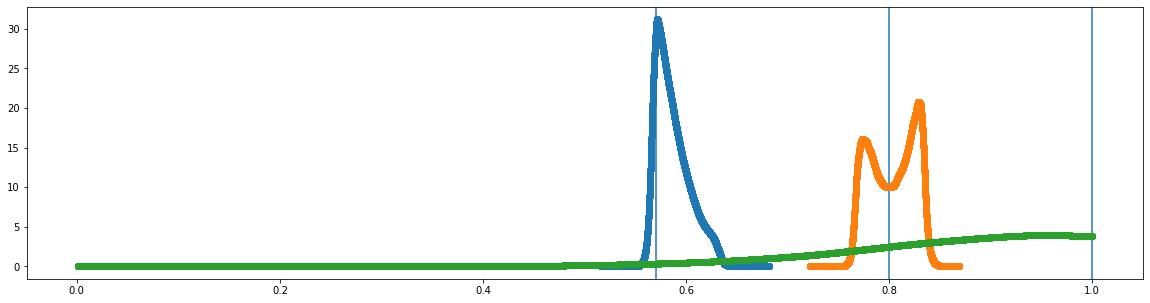

In [40]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p, marker='o')
#plt.gca().set_yscale('log')
len(ds)

In [41]:
sw_list[-1].trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = MAX_EPOCHS, nbatch = 128, lr_schedule = [1e-4])

Start training
LR iteration 0
Total epochs: 16
Validation losses: [6.209055066108704, 5.972138404846191, 5.5884153842926025, 5.419115424156189, 5.020537257194519, 4.725928068161011, 4.49297571182251, 4.536989808082581, 4.4867706298828125, 4.275883078575134, 4.359176993370056, 4.258398056030273, 4.089260518550873, 4.295113563537598, 4.236240863800049, 4.1878029108047485]


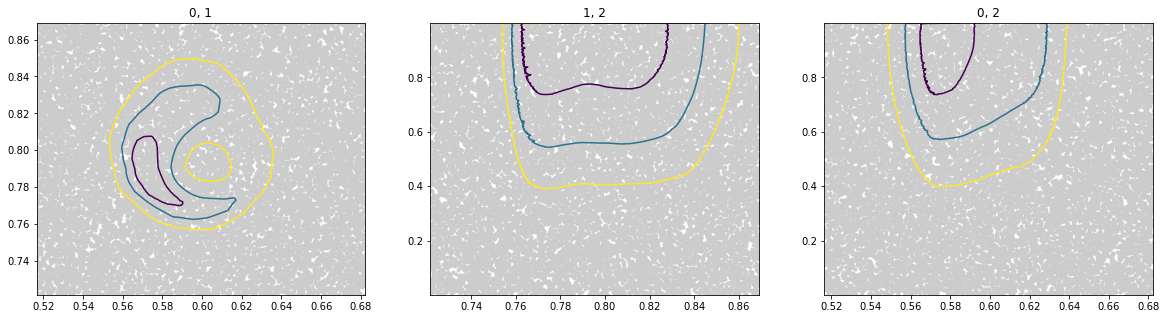

In [42]:
c = 1
plt.figure(figsize=(20, 5))
for i, j in [[0, 1], [1, 2], [0, 2]]:
    zgrid, lnLgrid = sw_list[-1].posterior([i, j])
    plt.subplot(1, 3, c)
    c+=1
    plt.title("%i, %i"%(i, j))
    plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
    max_lnL = lnLgrid[:].max()
    plt.tricontour(zgrid[:,0], zgrid[:,1], (-lnLgrid+max_lnL)*2, levels = [1, 4, 9])

In [12]:
z = np.array(ds.z)

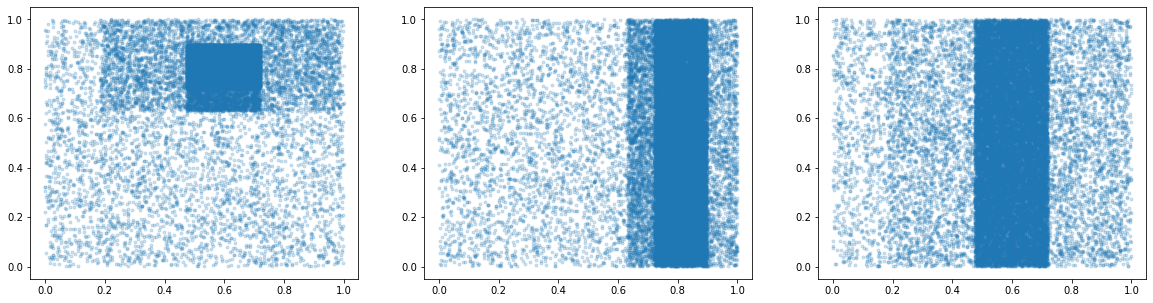

In [13]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(z[:,0], z[:,1], marker='.', alpha = 0.2)
plt.subplot(132)
plt.scatter(z[:,1], z[:,2], marker='.', alpha = 0.2)
plt.subplot(133)
plt.scatter(z[:,0], z[:,2], marker='.', alpha = 0.2)

# corner plots

In [43]:
n_unique = 200
#z_unique = torch.stack(
z_unique = [{"z": z} for z in torch.stack(
    torch.meshgrid([
        #UPDATE!!!
        torch.linspace(0.54, 0.66, n_unique),
        torch.linspace(0.74, 0.86, n_unique),
        torch.linspace(0.0, 1.0, 100),
    ])
).flatten(1).t()]

In [44]:
def get_lnLs(net, x, z_unique):
    """
    Gets lnL evaluated over the specified unique z values
    """
    z_grid, lnL_grid = swyft.posteriors(
        x.to(DEVICE), net, z_unique, combinations=[[0, 1],[1,2],[0,2]], device=DEVICE
    )
    z_grid = z_grid.squeeze()  # <--- map z to physical parameters here
    lnL_grid = lnL_grid.squeeze()
    return (
        #z_grid[:, 0],#.reshape([n_unique, n_unique,n_unique]),
        #z_grid[:, 1],#.reshape([n_unique, n_unique,n_unique]),
        #z_grid[:, 2],#.reshape([n_unique, n_unique,n_unique]),
        lnL_grid.exp()#.reshape([n_unique, n_unique,n_unique])
    )

In [45]:
zz=swyft.get_z(z_unique)
zz=np.array([np.ravel(elm.numpy()) for elm in zz])

In [46]:
Ls=get_lnLs(sw.netNd["default"]['net'], torch.tensor(x0).float(),z_unique)

In [47]:
weightsxy=Ls[:,0].numpy()

In [48]:
weightsxr=Ls[:,2].numpy()

In [49]:
weightsyr=Ls[:,1].numpy()

In [50]:
out=swyft.posteriors(torch.tensor(x0).float().to(DEVICE),sw.net1d,z_unique,device=DEVICE)

In [51]:
weightsx=np.exp(out[1].numpy()[:,0])
weightsy=np.exp(out[1].numpy()[:,1])
weightsr=np.exp(out[1].numpy()[:,2])

In [52]:
bW=np.array([weightsx,weightsy,weightsr,
                                weightsxy,weightsxr,weightsyr])

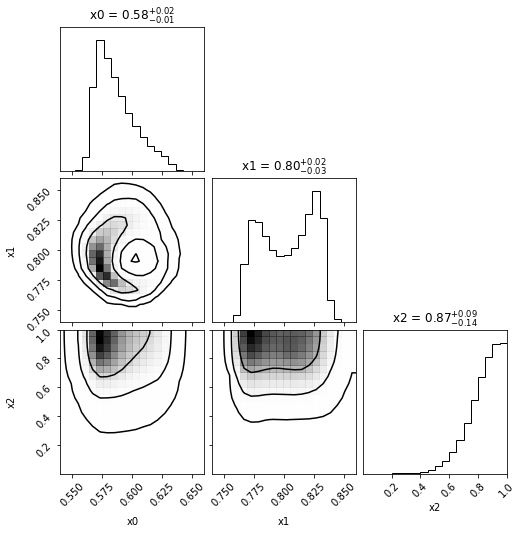

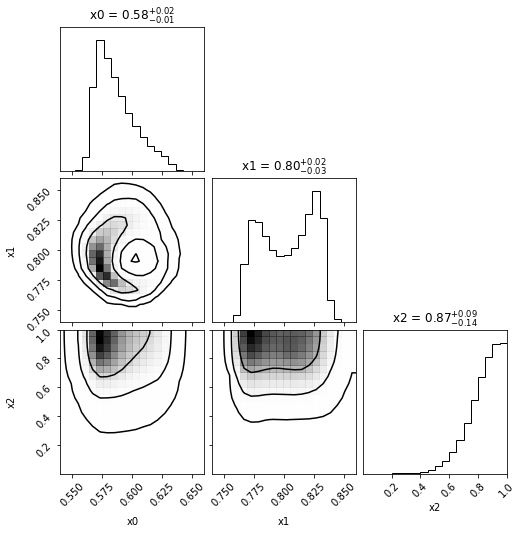

In [54]:
cornerAlt(zz,weights=bW,plot_datapoints=False,bins=20,
          #levels=(1-np.exp(-0.5*np.arange(1,3.1,1)**2)),
          levels=(0.68,0.95,0.997),
          show_titles=True,
         labels=['x0','x1','x2'],
         range=[(0.54,0.66),(0.74,0.86),(0,1)])

In [21]:
import logging
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator, NullLocator
from matplotlib.colors import LinearSegmentedColormap, colorConverter
from matplotlib.ticker import ScalarFormatter

try:
    from scipy.ndimage import gaussian_filter
except ImportError:
    gaussian_filter = None

__all__ = ["cornerAlt", "hist2d", "quantile"]


def cornerAlt(xs, bins=20, range=None, weights=None, color="k", hist_bin_factor=1,
           smooth=None, smooth1d=None,
           labels=None, label_kwargs=None,
           show_titles=False, title_fmt=".2f", title_kwargs=None,
           truths=None, truth_color="#4682b4",
           scale_hist=False, quantiles=None, verbose=False, fig=None,
           max_n_ticks=5, top_ticks=False, use_math_text=False, reverse=False,
           hist_kwargs=None, **hist2d_kwargs):
    """
    Make a *sick* corner plot showing the projections of a data set in a
    multi-dimensional space. kwargs are passed to hist2d() or used for
    `matplotlib` styling.
    Parameters
    ----------
    xs : array_like[nsamples, ndim]
        The samples. This should be a 1- or 2-dimensional array. For a 1-D
        array this results in a simple histogram. For a 2-D array, the zeroth
        axis is the list of samples and the next axis are the dimensions of
        the space.
    bins : int or array_like[ndim,]
        The number of bins to use in histograms, either as a fixed value for
        all dimensions, or as a list of integers for each dimension.
    weights : array_like[nsamples,]
        The weight of each sample. If `None` (default), samples are given
        equal weight.
    color : str
        A ``matplotlib`` style color for all histograms.
    hist_bin_factor : float or array_like[ndim,]
        This is a factor (or list of factors, one for each dimension) that
        will multiply the bin specifications when making the 1-D histograms.
        This is generally used to increase the number of bins in the 1-D plots
        to provide more resolution.
    smooth, smooth1d : float
       The standard deviation for Gaussian kernel passed to
       `scipy.ndimage.gaussian_filter` to smooth the 2-D and 1-D histograms
       respectively. If `None` (default), no smoothing is applied.
    labels : iterable (ndim,)
        A list of names for the dimensions. If a ``xs`` is a
        ``pandas.DataFrame``, labels will default to column names.
    label_kwargs : dict
        Any extra keyword arguments to send to the `set_xlabel` and
        `set_ylabel` methods.
    show_titles : bool
        Displays a title above each 1-D histogram showing the 0.5 quantile
        with the upper and lower errors supplied by the quantiles argument.
    title_fmt : string
        The format string for the quantiles given in titles. If you explicitly
        set ``show_titles=True`` and ``title_fmt=None``, the labels will be
        shown as the titles. (default: ``.2f``)
    title_kwargs : dict
        Any extra keyword arguments to send to the `set_title` command.
    range : iterable (ndim,)
        A list where each element is either a length 2 tuple containing
        lower and upper bounds or a float in range (0., 1.)
        giving the fraction of samples to include in bounds, e.g.,
        [(0.,10.), (1.,5), 0.999, etc.].
        If a fraction, the bounds are chosen to be equal-tailed.
    truths : iterable (ndim,)
        A list of reference values to indicate on the plots.  Individual
        values can be omitted by using ``None``.
    truth_color : str
        A ``matplotlib`` style color for the ``truths`` makers.
    scale_hist : bool
        Should the 1-D histograms be scaled in such a way that the zero line
        is visible?
    quantiles : iterable
        A list of fractional quantiles to show on the 1-D histograms as
        vertical dashed lines.
    verbose : bool
        If true, print the values of the computed quantiles.
    plot_contours : bool
        Draw contours for dense regions of the plot.
    use_math_text : bool
        If true, then axis tick labels for very large or small exponents will
        be displayed as powers of 10 rather than using `e`.
    reverse : bool
        If true, plot the corner plot starting in the upper-right corner
        instead of the usual bottom-left corner
    max_n_ticks: int
        Maximum number of ticks to try to use
    top_ticks : bool
        If true, label the top ticks of each axis
    fig : matplotlib.Figure
        Overplot onto the provided figure object.
    hist_kwargs : dict
        Any extra keyword arguments to send to the 1-D histogram plots.
    **hist2d_kwargs
        Any remaining keyword arguments are sent to `corner.hist2d` to generate
        the 2-D histogram plots.
    """
    if quantiles is None:
        quantiles = []
    if title_kwargs is None:
        title_kwargs = dict()
    if label_kwargs is None:
        label_kwargs = dict()

    # Try filling in labels from pandas.DataFrame columns.
    if labels is None:
        try:
            labels = xs.columns
        except AttributeError:
            pass

    # Deal with 1D sample lists.
    xs = np.atleast_1d(xs)
    if len(xs.shape) == 1:
        xs = np.atleast_2d(xs)
    else:
        assert len(xs.shape) == 2, "The input sample array must be 1- or 2-D."
        xs = xs.T
    assert xs.shape[0] <= xs.shape[1], "I don't believe that you want more " \
                                       "dimensions than samples!"
    #modify to have one set of weights for each 1-dimensional and 2-dimensional posterior
    #specify to two-parameter model for now --> three sets of weights
    # Parse the weight array.
    if weights is not None:
        weights = np.asarray(weights)
        #if weights.ndim != 1:
        #    raise ValueError("Weights must be 1-D")
        #if xs.shape[1] != weights.shape[0]:
        #    raise ValueError("Lengths of weights must match number of samples")

    # Parse the parameter ranges.
    if range is None:
        if "extents" in hist2d_kwargs:
            logging.warn("Deprecated keyword argument 'extents'. "
                         "Use 'range' instead.")
            range = hist2d_kwargs.pop("extents")
        else:
            range = [[x.min(), x.max()] for x in xs]
            # Check for parameters that never change.
            m = np.array([e[0] == e[1] for e in range], dtype=bool)
            if np.any(m):
                raise ValueError(("It looks like the parameter(s) in "
                                  "column(s) {0} have no dynamic range. "
                                  "Please provide a `range` argument.")
                                 .format(", ".join(map(
                                     "{0}".format, np.arange(len(m))[m]))))

    else:
        # If any of the extents are percentiles, convert them to ranges.
        # Also make sure it's a normal list.
        range = list(range)
        for i, _ in enumerate(range):
            try:
                emin, emax = range[i]
            except TypeError:
                q = [0.5 - 0.5*range[i], 0.5 + 0.5*range[i]]
                range[i] = quantile(xs[i], q, weights=weights)

    if len(range) != xs.shape[0]:
        raise ValueError("Dimension mismatch between samples and range")

    # Parse the bin specifications.
    try:
        bins = [int(bins) for _ in range]
    except TypeError:
        if len(bins) != len(range):
            raise ValueError("Dimension mismatch between bins and range")
    try:
        hist_bin_factor = [float(hist_bin_factor) for _ in range]
    except TypeError:
        if len(hist_bin_factor) != len(range):
            raise ValueError("Dimension mismatch between hist_bin_factor and "
                             "range")

    # Some magic numbers for pretty axis layout.
    K = len(xs)
    factor = 2.0           # size of one side of one panel
    if reverse:
        lbdim = 0.2 * factor   # size of left/bottom margin
        trdim = 0.5 * factor   # size of top/right margin
    else:
        lbdim = 0.5 * factor   # size of left/bottom margin
        trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    if fig is None:
        fig, axes = pl.subplots(K, K, figsize=(dim, dim))
    else:
        try:
            axes = np.array(fig.axes).reshape((K, K))
        except:
            raise ValueError("Provided figure has {0} axes, but data has "
                             "dimensions K={1}".format(len(fig.axes), K))

    # Format the figure.
    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    # Set up the default histogram keywords.
    if hist_kwargs is None:
        hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", color)
    if smooth1d is None:
        hist_kwargs["histtype"] = hist_kwargs.get("histtype", "step")

    for i, x in enumerate(xs):
        # Deal with masked arrays.
        if hasattr(x, "compressed"):
            x = x.compressed()

        if np.shape(xs)[0] == 1:
            ax = axes
        else:
            if reverse:
                ax = axes[K-i-1, K-i-1]
            else:
                ax = axes[i, i]
        # Plot the histograms.
        #UPDATE to use weights[i], currently assume i=0,1 for 1-dim posteriors
        if smooth1d is None:
            bins_1d = int(max(1, np.round(hist_bin_factor[i] * bins[i])))
            n, _, _ = ax.hist(x, bins=bins_1d, weights=weights[i],
                              range=np.sort(range[i]), **hist_kwargs)
        else:
            if gaussian_filter is None:
                raise ImportError("Please install scipy for smoothing")
            n, b = np.histogram(x, bins=bins[i], weights=weights,
                                range=np.sort(range[i]))
            n = gaussian_filter(n, smooth1d)
            x0 = np.array(list(zip(b[:-1], b[1:]))).flatten()
            y0 = np.array(list(zip(n, n))).flatten()
            ax.plot(x0, y0, **hist_kwargs)

        if truths is not None and truths[i] is not None:
            ax.axvline(truths[i], color=truth_color)

        # Plot quantiles if wanted.
        #use weights[i]!
        if len(quantiles) > 0:
            qvalues = quantile(x, quantiles, weights=weights[i])
            for q in qvalues:
                ax.axvline(q, ls="dashed", color=color)

            if verbose:
                print("Quantiles:")
                print([item for item in zip(quantiles, qvalues)])

        if show_titles:
            title = None
            if title_fmt is not None:
                # Compute the quantiles for the title. This might redo
                # unneeded computation but who cares.
                q_16, q_50, q_84 = quantile(x, [0.16, 0.5, 0.84],
                                            weights=weights[i])
                q_m, q_p = q_50-q_16, q_84-q_50

                # Format the quantile display.
                fmt = "{{0:{0}}}".format(title_fmt).format
                title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
                title = title.format(fmt(q_50), fmt(q_m), fmt(q_p))

                # Add in the column name if it's given.
                if labels is not None:
                    title = "{0} = {1}".format(labels[i], title)

            elif labels is not None:
                title = "{0}".format(labels[i])

            if title is not None:
                if reverse:
                    ax.set_xlabel(title, **title_kwargs)
                else:
                    ax.set_title(title, **title_kwargs)

        # Set up the axes.
        ax.set_xlim(range[i])
        if scale_hist:
            maxn = np.max(n)
            ax.set_ylim(-0.1 * maxn, 1.1 * maxn)
        else:
            ax.set_ylim(0, 1.1 * np.max(n))
        ax.set_yticklabels([])
        if max_n_ticks == 0:
            ax.xaxis.set_major_locator(NullLocator())
            ax.yaxis.set_major_locator(NullLocator())
        else:
            ax.xaxis.set_major_locator(MaxNLocator(max_n_ticks, prune="lower"))
            ax.yaxis.set_major_locator(NullLocator())

        if i < K - 1:
            if top_ticks:
                ax.xaxis.set_ticks_position("top")
                [l.set_rotation(45) for l in ax.get_xticklabels()]
            else:
                ax.set_xticklabels([])
        else:
            if reverse:
                ax.xaxis.tick_top()
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            if labels is not None:
                if reverse:
                    ax.set_title(labels[i], y=1.25, **label_kwargs)
                else:
                    ax.set_xlabel(labels[i], **label_kwargs)

            # use MathText for axes ticks
            ax.xaxis.set_major_formatter(
                ScalarFormatter(useMathText=use_math_text))

        for j, y in enumerate(xs):
            if i==0 and j==1 or i==1 and j==0:
                weightI=3
            elif i==0 and j==2 or i==2 and j==0:
                weightI=4
            elif i==1 and j==2 or i==2 and j==1:
                weightI=5
            if np.shape(xs)[0] == 1:
                ax = axes
            else:
                if reverse:
                    ax = axes[K-i-1, K-j-1]
                else:
                    ax = axes[i, j]
            if j > i:
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                continue

            # Deal with masked arrays.
            if hasattr(y, "compressed"):
                y = y.compressed()
            #Here is the hist2d, use weights[2]!
            hist2d(y, x, ax=ax, range=[range[j], range[i]], weights=weights[weightI],
                   color=color, smooth=smooth, bins=[bins[j], bins[i]],
                   **hist2d_kwargs)

            if truths is not None:
                if truths[i] is not None and truths[j] is not None:
                    ax.plot(truths[j], truths[i], "s", color=truth_color)
                if truths[j] is not None:
                    ax.axvline(truths[j], color=truth_color)
                if truths[i] is not None:
                    ax.axhline(truths[i], color=truth_color)

            if max_n_ticks == 0:
                ax.xaxis.set_major_locator(NullLocator())
                ax.yaxis.set_major_locator(NullLocator())
            else:
                ax.xaxis.set_major_locator(MaxNLocator(max_n_ticks,
                                                       prune="lower"))
                ax.yaxis.set_major_locator(MaxNLocator(max_n_ticks,
                                                       prune="lower"))

            if i < K - 1:
                ax.set_xticklabels([])
            else:
                if reverse:
                    ax.xaxis.tick_top()
                [l.set_rotation(45) for l in ax.get_xticklabels()]
                if labels is not None:
                    ax.set_xlabel(labels[j], **label_kwargs)
                    if reverse:
                        ax.xaxis.set_label_coords(0.5, 1.4)
                    else:
                        ax.xaxis.set_label_coords(0.5, -0.3)

                # use MathText for axes ticks
                ax.xaxis.set_major_formatter(
                    ScalarFormatter(useMathText=use_math_text))

            if j > 0:
                ax.set_yticklabels([])
            else:
                if reverse:
                    ax.yaxis.tick_right()
                [l.set_rotation(45) for l in ax.get_yticklabels()]
                if labels is not None:
                    if reverse:
                        ax.set_ylabel(labels[i], rotation=-90, **label_kwargs)
                        ax.yaxis.set_label_coords(1.3, 0.5)
                    else:
                        ax.set_ylabel(labels[i], **label_kwargs)
                        ax.yaxis.set_label_coords(-0.3, 0.5)

                # use MathText for axes ticks
                ax.yaxis.set_major_formatter(
                    ScalarFormatter(useMathText=use_math_text))

    return fig


def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()


def hist2d(x, y, bins=20, range=None, weights=None, levels=None, smooth=None,
           ax=None, color=None, quiet=False,
           plot_datapoints=True, plot_density=True,
           plot_contours=True, no_fill_contours=False, fill_contours=False,
           contour_kwargs=None, contourf_kwargs=None, data_kwargs=None,
           pcolor_kwargs=None, **kwargs):
           
    """
    Plot a 2-D histogram of samples.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    y : array_like[nsamples,]
       The samples.
    quiet : bool
        If true, suppress warnings for small datasets.
    levels : array_like
        The contour levels to draw.
    ax : matplotlib.Axes
        A axes instance on which to add the 2-D histogram.
    plot_datapoints : bool
        Draw the individual data points.
    plot_density : bool
        Draw the density colormap.
    plot_contours : bool
        Draw the contours.
    no_fill_contours : bool
        Add no filling at all to the contours (unlike setting
        ``fill_contours=False``, which still adds a white fill at the densest
        points).
    fill_contours : bool
        Fill the contours.
    contour_kwargs : dict
        Any additional keyword arguments to pass to the `contour` method.
    contourf_kwargs : dict
        Any additional keyword arguments to pass to the `contourf` method.
    data_kwargs : dict
        Any additional keyword arguments to pass to the `plot` method when
        adding the individual data points.
    pcolor_kwargs : dict
        Any additional keyword arguments to pass to the `pcolor` method when
        adding the density colormap.
    """
    if ax is None:
        ax = pl.gca()

    # Set the default range based on the data range if not provided.
    if range is None:
        if "extent" in kwargs:
            logging.warn("Deprecated keyword argument 'extent'. "
                         "Use 'range' instead.")
            range = kwargs["extent"]
        else:
            range = [[x.min(), x.max()], [y.min(), y.max()]]

    # Set up the default plotting arguments.
    if color is None:
        color = "k"

    # Choose the default "sigma" contour levels.
    if levels is None:
        levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

    # This is the color map for the density plot, over-plotted to indicate the
    # density of the points near the center.
    density_cmap = LinearSegmentedColormap.from_list(
        "density_cmap", [color, (1, 1, 1, 0)])

    # This color map is used to hide the points at the high density areas.
    white_cmap = LinearSegmentedColormap.from_list(
        "white_cmap", [(1, 1, 1), (1, 1, 1)], N=2)

    # This "color map" is the list of colors for the contour levels if the
    # contours are filled.
    rgba_color = colorConverter.to_rgba(color)
    contour_cmap = [list(rgba_color) for l in levels] + [rgba_color]
    for i, l in enumerate(levels):
        contour_cmap[i][-1] *= float(i) / (len(levels)+1)

    # We'll make the 2D histogram to directly estimate the density.
    try:
        H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=bins,
                                 range=list(map(np.sort, range)),
                                 weights=weights)
    except ValueError:
        raise ValueError("It looks like at least one of your sample columns "
                         "have no dynamic range. You could try using the "
                         "'range' argument.")

    if smooth is not None:
        if gaussian_filter is None:
            raise ImportError("Please install scipy for smoothing")
        H = gaussian_filter(H, smooth)

    if plot_contours or plot_density:
        # Compute the density levels.
        Hflat = H.flatten()
        inds = np.argsort(Hflat)[::-1]
        Hflat = Hflat[inds]
        sm = np.cumsum(Hflat)
        sm /= sm[-1]
        V = np.empty(len(levels))
        for i, v0 in enumerate(levels):
            try:
                V[i] = Hflat[sm <= v0][-1]
            except:
                V[i] = Hflat[0]
        V.sort()
        m = np.diff(V) == 0
        if np.any(m) and not quiet:
            logging.warning("Too few points to create valid contours")
        while np.any(m):
            V[np.where(m)[0][0]] *= 1.0 - 1e-4
            m = np.diff(V) == 0
        V.sort()

        # Compute the bin centers.
        X1, Y1 = 0.5 * (X[1:] + X[:-1]), 0.5 * (Y[1:] + Y[:-1])

        # Extend the array for the sake of the contours at the plot edges.
        H2 = H.min() + np.zeros((H.shape[0] + 4, H.shape[1] + 4))
        H2[2:-2, 2:-2] = H
        H2[2:-2, 1] = H[:, 0]
        H2[2:-2, -2] = H[:, -1]
        H2[1, 2:-2] = H[0]
        H2[-2, 2:-2] = H[-1]
        H2[1, 1] = H[0, 0]
        H2[1, -2] = H[0, -1]
        H2[-2, 1] = H[-1, 0]
        H2[-2, -2] = H[-1, -1]
        X2 = np.concatenate([
            X1[0] + np.array([-2, -1]) * np.diff(X1[:2]),
            X1,
            X1[-1] + np.array([1, 2]) * np.diff(X1[-2:]),
        ])
        Y2 = np.concatenate([
            Y1[0] + np.array([-2, -1]) * np.diff(Y1[:2]),
            Y1,
            Y1[-1] + np.array([1, 2]) * np.diff(Y1[-2:]),
        ])

    if plot_datapoints:
        if data_kwargs is None:
            data_kwargs = dict()
        data_kwargs["color"] = data_kwargs.get("color", color)
        data_kwargs["ms"] = data_kwargs.get("ms", 2.0)
        data_kwargs["mec"] = data_kwargs.get("mec", "none")
        data_kwargs["alpha"] = data_kwargs.get("alpha", 0.1)
        ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)

    # Plot the base fill to hide the densest data points.
    if (plot_contours or plot_density) and not no_fill_contours:
        ax.contourf(X2, Y2, H2.T, [V.min(), H.max()],
                    cmap=white_cmap, antialiased=False)

    if plot_contours and fill_contours:
        if contourf_kwargs is None:
            contourf_kwargs = dict()
        contourf_kwargs["colors"] = contourf_kwargs.get("colors", contour_cmap)
        contourf_kwargs["antialiased"] = contourf_kwargs.get("antialiased",
                                                             False)
        ax.contourf(X2, Y2, H2.T, np.concatenate([[0], V, [H.max()*(1+1e-4)]]),
                    **contourf_kwargs)

    # Plot the density map. This can't be plotted at the same time as the
    # contour fills.
    elif plot_density:
        if pcolor_kwargs is None:
            pcolor_kwargs = dict()
        ax.pcolor(X, Y, H.max() - H.T, cmap=density_cmap, **pcolor_kwargs)

    # Plot the contour edge colors.
    if plot_contours:
        if contour_kwargs is None:
            contour_kwargs = dict()
        contour_kwargs["colors"] = contour_kwargs.get("colors", color)
        ax.contour(X2, Y2, H2.T, V, **contour_kwargs)

    ax.set_xlim(range[0])
    ax.set_ylim(range[1])